### Import Libraries

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import roc_auc_score, roc_curve
from scipy.stats import zscore
from sklearn.metrics import roc_auc_score
from sklearn.metrics import precision_recall_fscore_support as score
from sklearn.model_selection import cross_val_score
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import CountVectorizer
from surprise import KNNWithMeans
from collections import defaultdict
from surprise import SVD
from surprise import Dataset
from sklearn.model_selection import train_test_split
from scipy.sparse.linalg import svds
from scipy.sparse import csr_matrix
import sklearn.metrics as metrics
from sklearn.neighbors import NearestNeighbors
from surprise import SVD, KNNWithMeans
from surprise import accuracy
from surprise import Dataset,Reader

#### 1 A. Merge all the provided CSVs into one dataFrame.

In [2]:
os.chdir('C:/Users/Sai/Desktop/GL/Project6/Data_Set')

In [3]:
df1 = pd.read_csv("phone_user_review_file_1.csv", encoding = "ISO-8859-1") 
df2 = pd.read_csv("phone_user_review_file_2.csv", encoding = "ISO-8859-1") 
df3 = pd.read_csv("phone_user_review_file_3.csv", encoding = "ISO-8859-1") 
df4 = pd.read_csv("phone_user_review_file_4.csv", encoding = "ISO-8859-1") 
df5 = pd.read_csv("phone_user_review_file_5.csv", encoding = "ISO-8859-1") 
df6 = pd.read_csv("phone_user_review_file_6.csv", encoding = "ISO-8859-1") 

In [4]:
ndf = pd.concat([df1,df2,df3,df4,df5,df6], axis = 0)
ndf.head()

,phone_url,date,lang,country,source,domain,score,score_max,extract,author,product
0,/cellphones/samsung-galaxy-s8/,5/2/2017,en,us,Verizon Wireless,verizonwireless.com,10.0,10.0,As a diehard Samsung fan who has had every Sam...,CarolAnn35,Samsung Galaxy S8
1,/cellphones/samsung-galaxy-s8/,4/28/2017,en,us,Phone Arena,phonearena.com,10.0,10.0,Love the phone. the phone is sleek and smooth ...,james0923,Samsung Galaxy S8
2,/cellphones/samsung-galaxy-s8/,5/4/2017,en,us,Amazon,amazon.com,6.0,10.0,Adequate feel. Nice heft. Processor's still sl...,R. Craig,"Samsung Galaxy S8 (64GB) G950U 5.8"" 4G LTE Unl..."
3,/cellphones/samsung-galaxy-s8/,5/2/2017,en,us,Samsung,samsung.com,9.2,10.0,Never disappointed. One of the reasons I've be...,Buster2020,Samsung Galaxy S8 64GB (AT&T)
4,/cellphones/samsung-galaxy-s8/,5/11/2017,en,us,Verizon Wireless,verizonwireless.com,4.0,10.0,I've now found that i'm in a group of people t...,S Ate Mine,Samsung Galaxy S8


In [5]:
ndf.shape

(1415133, 11)

#### 1 B Explore, understand the Data and share at least 2 observations.

In [6]:
ndf.dtypes

phone_url     object
date          object
lang          object
country       object
source        object
domain        object
score        float64
score_max    float64
extract       object
author        object
product       object
dtype: object

In [7]:
ndf.describe().T

,count,mean,std,min,25%,50%,75%,max
score,1351644.0,8.00706,2.616121,0.2,7.2,9.2,10.0,10.0
score_max,1351644.0,10.00000,0.000000,10.0,10.0,10.0,10.0,10.0


C:\ProgramData\Anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


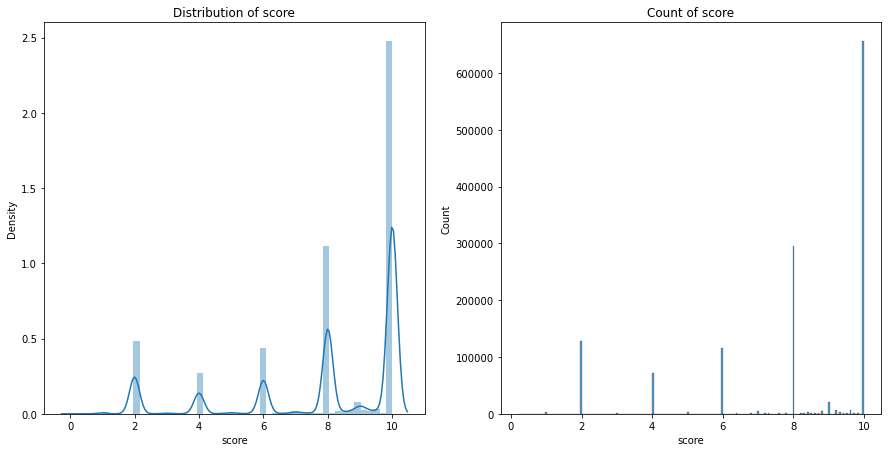

In [8]:
fig = plt.figure(figsize = (15, 7.2))
ax = fig.add_subplot(121)
g = sns.distplot(ndf['score'], ax = ax).set_title('Distribution of score')
ax = fig.add_subplot(122)
g = sns.histplot(ndf['score']).set_title('Count of score')

#### Observations
<li> The mean score is 8 and standard diviation is 2.6
<li> Minimum score is 0.2 and the maximum score is 10
<li> score 10 is highly distributed in the data

#### 1 C. Round off scores to the nearest integers.

In [9]:
ndf.score = ndf.score.round()
ndf.head()

,phone_url,date,lang,country,source,domain,score,score_max,extract,author,product
0,/cellphones/samsung-galaxy-s8/,5/2/2017,en,us,Verizon Wireless,verizonwireless.com,10.0,10.0,As a diehard Samsung fan who has had every Sam...,CarolAnn35,Samsung Galaxy S8
1,/cellphones/samsung-galaxy-s8/,4/28/2017,en,us,Phone Arena,phonearena.com,10.0,10.0,Love the phone. the phone is sleek and smooth ...,james0923,Samsung Galaxy S8
2,/cellphones/samsung-galaxy-s8/,5/4/2017,en,us,Amazon,amazon.com,6.0,10.0,Adequate feel. Nice heft. Processor's still sl...,R. Craig,"Samsung Galaxy S8 (64GB) G950U 5.8"" 4G LTE Unl..."
3,/cellphones/samsung-galaxy-s8/,5/2/2017,en,us,Samsung,samsung.com,9.0,10.0,Never disappointed. One of the reasons I've be...,Buster2020,Samsung Galaxy S8 64GB (AT&T)
4,/cellphones/samsung-galaxy-s8/,5/11/2017,en,us,Verizon Wireless,verizonwireless.com,4.0,10.0,I've now found that i'm in a group of people t...,S Ate Mine,Samsung Galaxy S8


#### 1 D. Check for missing values. Impute the missing values, if any.

In [10]:
ndf = ndf.replace(r'^\s*$', np.nan, regex=True)
missing_values = ["?","-",""]
ndfnew = ndf.replace(missing_values, np.nan)

In [11]:
print('Number of missing values across columns: \n', ndf.isnull().sum())

Number of missing values across columns: 
 phone_url        0
date             0
lang             0
country          0
source           0
domain           0
score        63489
score_max    63489
extract      19361
author       63202
product          1
dtype: int64


In [12]:
ndf.dropna(inplace=True)

In [13]:
ndf.isnull().sum()

phone_url    0
date         0
lang         0
country      0
source       0
domain       0
score        0
score_max    0
extract      0
author       0
product      0
dtype: int64

#### 1 E Check for duplicate values and remove them, if any.

In [14]:
ndf.duplicated()

0         False
1         False
2         False
3         False
4         False
          ...  
163832    False
163833    False
163834    False
163835    False
163836    False
Length: 1275917, dtype: bool

In [15]:
len(ndf)-len(ndf.drop_duplicates())

4480

#### 1 F Keep only 1 Million data samples. Use random state=612.

In [16]:
ndf_sampled = ndf.sample(n=10000,random_state=612)

In [17]:
ndf_sampled.head()

,phone_url,date,lang,country,source,domain,score,score_max,extract,author,product
292711,/cellphones/alcatel-onetouch-20-04/,1/20/2016,it,it,Amazon,amazon.it,6.0,10.0,Ho comprato questo telefono circa un anno fa p...,Giuseppe Calavaro,"Alcatel One Touch 20-04G Telefono Cellulare, Nero"
78482,/cellphones/huawei-m750/,3/24/2011,en,us,Phone Arena,phonearena.com,2.0,10.0,"I had a Samsung Freeform from Cleartalk, and I...",Buraian22,Huawei M750
126183,/cellphones/nokia-c7-00i/,5/24/2012,ru,ru,Yandex,market.yandex.ru,10.0,10.0,ÐÐ´ÐµÐ°Ð»ÑÐ½ÑÐ¹ Ð°Ð¿Ð¿Ð°ÑÐ°Ñ.Ð¡ÐµÐ½ÑÐ¾Ñ...,badamyan.karen,Nokia C7-00
32139,/cellphones/binatone-sm800/,4/3/2015,en,gb,Amazon,amazon.co.uk,10.0,10.0,Being of the older generation and fed up with ...,Amazon Customer,Binatone SM800 Touch Screen Big Button Sim Fre...
17325,/cellphones/samsung-galaxy-s7-edge/,10/2/2016,nl,nl,Bol.com,bol.com,6.0,10.0,"Mooi toestel, helaas te vaak vastlopers En toc...",unknown,Samsung Samsung Galaxy A5 2016 - Wit


In [18]:
ndf_sampled.shape

(10000, 11)

#### 1 G Drop irrelevant features. Keep features like Author, Product, and Score.

##### for 1 Million data samples:

In [19]:
ndfnew = ndf_sampled.drop(["phone_url","date","lang","score_max", "country", "source", "domain", "extract"], axis=1).copy()

In [20]:
ndfnew.head()

,score,author,product
292711,6.0,Giuseppe Calavaro,"Alcatel One Touch 20-04G Telefono Cellulare, Nero"
78482,2.0,Buraian22,Huawei M750
126183,10.0,badamyan.karen,Nokia C7-00
32139,10.0,Amazon Customer,Binatone SM800 Touch Screen Big Button Sim Fre...
17325,6.0,unknown,Samsung Samsung Galaxy A5 2016 - Wit


##### Full dataset:

In [21]:
ndfnew_full = ndf.drop(["phone_url","date","lang","score_max", "country", "source", "domain", "extract"], axis=1).copy()

In [22]:
ndfnew_full.shape

(1275917, 3)

#### 2 A. Identify the most rated products.

In [23]:
print('Most rated products:'); print('--'*30)
most_rated = ndfnew.groupby('product')['score'].mean().sort_values(ascending=False).head()
most_rated

Most rated products:
------------------------------------------------------------


product
Nokia 215 Telefono Cellulare, Dual SIM, Verde [Italia]                                                                                 10.0
Samsung Galaxy S6 Edge G925i 32GB Unlocked GSM LTE Octa-Core Phone w/ 16MP Camera - Green Emerald INTERNATIONAL VERSION NO WARRANTY    10.0
Samsung Galaxy S6 Edge SM-G925 32GB                                                                                                    10.0
Samsung Galaxy S6 Edge Plus SM-G928 64GB Cell Phone - International Version no warranty                                                10.0
LG Optimus Logic in White (Net10)                                                                                                      10.0
Name: score, dtype: float64

In [24]:
print('Most rated products:'); print('--'*30)
most_rated_full = ndfnew_full.groupby('product')['score'].mean().sort_values(ascending=False).head()
most_rated_full

Most rated products:
------------------------------------------------------------


product
æ©æç½æ C168i                                                                                                                        10.0
LG K8 Indigo LGK350DS.ABRAKU Dual Chip Android 6.0 Marshmallow 4G Wi-Fi CÃ¢mera 8 MP                                                      10.0
BlackBerry Curve 9320 smartphone on T-Mobile pay as you go                                                                                10.0
Samsung Galaxy S6 edge SM-G925F - Smartphone de 5.1" (12,954 cm, 2560 x 1440 pixeles, SAMOLED, 2,1 GHz, 1,5 GHz, 3072 MB), color verde    10.0
Sony Xperia Z3 Compact Black VF                                                                                                           10.0
Name: score, dtype: float64

#### 2 B. Identify the users with most number of reviews.

##### 1 Million Data samples:

In [25]:
print('Most reviewed products:'); print('--'*15)
most_reviewed = ndfnew.groupby('author')['score'].count().sort_values(ascending=False).head()
most_reviewed

Most reviewed products:
------------------------------


author
Amazon Customer    639
Cliente Amazon     148
e-bit               65
Client d'Amazon     59
Amazon Kunde        30
Name: score, dtype: int64

##### Full Dataset:

In [26]:
print('Most reviewed products:'); print('--'*15)
most_reviewed_full = ndfnew_full.groupby('author')['score'].count().sort_values(ascending=False).head()
most_reviewed_full

Most reviewed products:
------------------------------


author
Amazon Customer    76978
Cliente Amazon     19304
e-bit               8663
Client d'Amazon     7716
Amazon Kunde        4750
Name: score, dtype: int64

#### 2 C. Select the data with products having more than 50 ratings and users who have given more than 50 ratings. Report the shape of the final dataset.

In [27]:
data_author=ndfnew_full.author.value_counts()
data_author

Amazon Customer       76978
Cliente Amazon        19304
e-bit                  8663
Client d'Amazon        7716
Amazon Kunde           4750
                      ...  
Ankit Mehta               1
Dean Sumith               1
Dee Brown                 1
Dhirajraj Adhikari        1
claudia0815               1
Name: author, Length: 770521, dtype: int64

In [28]:
data_author[data_author.values>=50].index.shape

(835,)

In [29]:
data_author_set=ndfnew_full[ndfnew_full['author'].isin(data_author[data_author>=50].index)]
data_author_set

,score,author,product
55,10.0,Anonymous,"Samsung Galaxy S8, 64Gb - Black"
66,10.0,James,"Samsung Galaxy S8, 64Gb - Orchid Grey"
68,10.0,Anonymous,"Samsung Galaxy S8, 64Gb - Orchid Grey"
106,10.0,James,"Samsung Galaxy S8, 64Gb - Orchid Grey"
161,10.0,Paul,"Samsung Galaxy S8, 64Gb - Black"
...,...,...,...
163004,8.0,anonym,Philips Savvy (new version)
163181,8.0,anonym,Motorola Star Tac 85
163233,4.0,doomer,Siemens M30
163609,4.0,anonym,Ericsson GF 768


In [30]:
data_score=data_author_set.score.value_counts()
data_score

10.0    114831
8.0      48766
2.0      30981
6.0      19564
4.0      12805
9.0       5291
7.0       1153
5.0        566
1.0        362
3.0        325
0.0          2
Name: score, dtype: int64

In [31]:
data_score_set=data_author_set[data_author_set['score'].isin(data_score[data_score>=50].index)]
data_finalset = data_score_set
data_finalset

,score,author,product
55,10.0,Anonymous,"Samsung Galaxy S8, 64Gb - Black"
66,10.0,James,"Samsung Galaxy S8, 64Gb - Orchid Grey"
68,10.0,Anonymous,"Samsung Galaxy S8, 64Gb - Orchid Grey"
106,10.0,James,"Samsung Galaxy S8, 64Gb - Orchid Grey"
161,10.0,Paul,"Samsung Galaxy S8, 64Gb - Black"
...,...,...,...
163004,8.0,anonym,Philips Savvy (new version)
163181,8.0,anonym,Motorola Star Tac 85
163233,4.0,doomer,Siemens M30
163609,4.0,anonym,Ericsson GF 768


In [32]:
data_finalset.shape

(234644, 3)

#### 3. Build a popularity based model and recommend top 5 mobile phones.

In [33]:
popularity_model = data_finalset.groupby('product').agg({'author':'count','score':'mean'}).reset_index()
popularity_model.rename(columns={'author':'count','score':'mean'},inplace=True)
popularity_model.head()

,product,count,mean
0,'Sony Xperia X (F5122) â White â Dual Sim ...,1,10.0
1,(DG300 Versione Aggiornata)5'' DOOGEE VOYAGER2...,16,8.0
2,**** PacK Exclusif A&d COFFRET WIKO **** Houss...,1,8.0
3,03 Apple MD300DN/A iPhone 5 32 GB Wei?? (GSM),2,6.0
4,100 - phantom black,1,10.0


In [34]:
popularity_model_sort = popularity_model.sort_values(['count'], ascending = 0) 
 
popularity_model_sort['Rank'] = popularity_model_sort['count'].rank(ascending=0, method='first') 
          
popularity_recommendations = popularity_model_sort.head(5) 
popularity_recommendations 

,product,count,mean,Rank
11236,"Lenovo Vibe K4 Note (White,16GB)",3139,6.997133,1.0
11235,"Lenovo Vibe K4 Note (Black, 16GB)",2614,7.030604,2.0
16018,"OnePlus 3 (Graphite, 64 GB)",1910,8.521466,3.0
16019,"OnePlus 3 (Soft Gold, 64 GB)",1822,8.301866,4.0
11239,"Lenovo Vibe K5 (Gold, VoLTE update)",1609,6.635177,5.0


#### 4. Build a collaborative filtering model using SVD. You can use SVD from surprise or build it from scratch(Note: Incase you’re building it from scratch youcan limit your data points to 5000 samples if you face memory issues). Build a collaborative filtering model using kNNWithMeans from surprise. Youcan try both user-based and item-based model.

In [35]:
train_data, test_data = train_test_split(data_finalset, test_size = 0.3, random_state=10)
train_data.head()

,score,author,product
199431,2.0,Sonia,Sony Xperia Z5 Compact Unlocked Phone - Black ...
179140,7.0,BB,Huawei P8lite zwart / 16 GB
61641,8.0,Mark,Huawei Ascend G6 (4G) (Genuine UK Stock) Sim F...
130483,10.0,Cliente Amazon,"Samsung Galaxy J5 - Smartphone de 5"" (1280 x 7..."
245977,10.0,ÐÐ»ÐµÐºÑÐµÐ¹,Sony Xperia SP (Ð±ÐµÐ»ÑÐ¹)


In [36]:
final_ratings_matrix = pd.pivot_table(data_finalset,index='author',columns='product',values = 'score').fillna(0)

In [37]:
given_num_of_ratings = np.count_nonzero(final_ratings_matrix)
print('given_num_of_ratings = ', given_num_of_ratings)
possible_num_of_ratings = final_ratings_matrix.shape[0] * final_ratings_matrix.shape[1]
print('possible_num_of_ratings = ', possible_num_of_ratings)
density = (given_num_of_ratings/possible_num_of_ratings)
density *= 100
print ('density: {:4.2f}%'.format(density))

given_num_of_ratings =  104712
possible_num_of_ratings =  22595100
density: 0.46%


In [38]:
final_ratings_matrix_T = final_ratings_matrix.transpose()
final_ratings_matrix_T.head()

author,#,.,91mobiles Customer,????????,??????????,????????????,???????????? ????????,???????????? ??????????,???????????? ????????????,???????????? ??????????????,...,ÐÐ¾Ð»ÑÐ·Ð¾Ð²Ð°ÑÐµÐ»Ñ ÑÐºÑÑÐ» ÑÐ²Ð¾Ð¸ Ð´Ð°Ð½Ð½ÑÐµ,Ð Ð¾Ð¼Ð°Ð½,Ð ÑÑÐ»Ð°Ð½,Ð¡Ð°ÑÐ°,Ð¡Ð²ÐµÑÐ»Ð°Ð½Ð°,Ð¡ÐµÑÐ³ÐµÐ¹,Ð¡ÑÐ°Ð½Ð¸ÑÐ»Ð°Ð²,Ð¢Ð°ÑÑÑÐ½Ð°,Ð®Ð»Ð¸Ñ,Ð®ÑÐ¸Ð¹
product,,,,,,,,,,,,,,,,,,,,,
"'Sony Xperia X (F5122) â White â Dual Sim (Google Android 6.0.1, 5 Display, 2 x CORTEX A72 1.8 GHz + 4 x cortex-a53...",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
"(DG300 Versione Aggiornata)5'' DOOGEE VOYAGER2 DG310 Dual Flashlights IPS Screen 3G Smartphone Android 4.4 MTK6582 1.3GHz Quad Core Telefono Cellulare Dual SIM 8G ROM OTG OTA GPS WIFI, BIANCO",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
**** PacK Exclusif A&d COFFRET WIKO **** Housse WIKO CINK FIVE Coque wiko cink five protection flip cover wiko...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
03 Apple MD300DN/A iPhone 5 32 GB Wei?? (GSM),0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
100 - phantom black,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [39]:
train_final_ratings_matrix = pd.pivot_table(train_data,index='author',columns='product',values = 'score').fillna(0)
test_final_ratings_matrix = pd.pivot_table(test_data,index='author',columns='product',values = 'score').fillna(0)

In [40]:
data_finalset['author_index'] = np.arange(0, data_finalset.shape[0], 1)
train_final_ratings_matrix['author_index'] = np.arange(0, train_final_ratings_matrix.shape[0], 1)
train_final_ratings_matrix.head()

C:\Users\Sai1\AppData\Local\Temp\ipykernel_19916\2526002894.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_finalset['author_index'] = np.arange(0, data_finalset.shape[0], 1)


product,"'Sony Xperia X (F5122) â White â Dual Sim (Google Android 6.0.1, 5 Display, 2 x CORTEX A72 1.8 GHz + 4 x cortex-a53...","(DG300 Versione Aggiornata)5'' DOOGEE VOYAGER2 DG310 Dual Flashlights IPS Screen 3G Smartphone Android 4.4 MTK6582 1.3GHz Quad Core Telefono Cellulare Dual SIM 8G ROM OTG OTA GPS WIFI, BIANCO",03 Apple MD300DN/A iPhone 5 32 GB Wei?? (GSM),100 - phantom black,101 - schwarz,1110 / 1112,1135,1st Film de protection d'Ã©cran en Verre trempÃ© pour Samsung Galaxy A3 Transparent,2014 Newest 4'' ZTE Open C Firefox OS 1.3 Unlocked 3G Smartphone Qualcomm Dual Core 1.2 GHz 4GB ROM 2.0MP Camera...,2014 Newest DOOGEE DAGGER DG550 5.5'' Unlocked Octa Core 1.7Ghz Android 4.2.9 OS 3G Smartphone -- 5-Point-Touch...,...,×××¤×× ×¡××××¨× Motorola Moto G 2nd Gen 2014,×××¤×× ×¡××××¨× OnePlus 3 64GB,×××¤×× ×¡××××¨× OnePlus 3T 64GB,×××¤×× ×¡××××¨× OnePlus One 64GB,×××¤×× ×¡××××¨× Samsung Galaxy A7 SM-A710F,×××¤×× ×¡××××¨× Samsung Galaxy S7 Edge SM-G935F 32GB,×××¤×× ×¡××××¨× Xiaomi Redmi 4A 16GB,×××¤×× ×¡××××¨× Xiaomi Redmi Note 3 Pro 32GB,×××¤×× ×¡××××¨× Xiaomi Redmi Note 4 64GB,author_index
author,,,,,,,,,,,,,,,,,,,,,
#,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
.,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
91mobiles Customer,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2
????????,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3
??????????,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4


In [41]:
test_final_ratings_matrix['author_index'] = np.arange(0, test_final_ratings_matrix.shape[0], 1)
test_final_ratings_matrix.head()

product,"(DG300 Versione Aggiornata)5'' DOOGEE VOYAGER2 DG310 Dual Flashlights IPS Screen 3G Smartphone Android 4.4 MTK6582 1.3GHz Quad Core Telefono Cellulare Dual SIM 8G ROM OTG OTA GPS WIFI, BIANCO",**** PacK Exclusif A&d COFFRET WIKO **** Housse WIKO CINK FIVE Coque wiko cink five protection flip cover wiko...,03 Apple MD300DN/A iPhone 5 32 GB Wei?? (GSM),1100,1600,"2014 neue Ankunfts-Cubot X6 MTK6592 Octa-Core 1,7 GHz Phone 5.0-Zoll-IPS-Bildschirm 1280x720p OGS 1GB RAM 16GB...",2015 Newest CUBOT X9 5.0'' Octa Core Android 4.4 Kitkat OS Unlocked 3G Smartphone -- IPS HD Touchscreen HotKnot MTK6592 Dual SIM Dual Standby Mobile Phone 2G RAM 16G ROM WIFI OTG GPS Finger Gesture Air Gesture Cellphone 3G Phablet (Golden),2015 Newest ZTE Blade S6 5'' Android 5.0 Lollipop Unlocked LTE 4G Smartphone -- IPS HD LCD 10-Points Touchscreen...,3 FILMS PROTECTION ECRAN SAMSUNG Galaxy Ace S5830 [Appareils Ã©lectroniques],3620,...,×××¤×× ×¡××××¨× LG Nexus 5 16GB D821,×××¤×× ×¡××××¨× LG Nexus 5X 16GB,×××¤×× ×¡××××¨× LG Nexus 5X 32GB,×××¤×× ×¡××××¨× OnePlus One 64GB,×××¤×× ×¡××××¨× Samsung Galaxy S7 SM-G930F 32GB,×××¤×× ×¡××××¨× Sony Xperia U,×××¤×× ×¡××××¨× Xiaomi Redmi Note 3 Pro 32GB,×××¤×× ×¡××××¨× Xiaomi Redmi Note 4 64GB,×××¤×× ×¡××××¨× iPhone 5s 16GB SimFree ××××¦×¨× Apple,author_index
author,,,,,,,,,,,,,,,,,,,,,
#,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
.,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
91mobiles Customer,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2
????????,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3
??????????,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4


In [42]:
data_finalset.set_index(['author_index'], inplace=True)

train_final_ratings_matrix.set_index(['author_index'], inplace=True)
train_final_ratings_matrix.head()

test_final_ratings_matrix.set_index(['author_index'], inplace=True)
test_final_ratings_matrix.head()

product,"(DG300 Versione Aggiornata)5'' DOOGEE VOYAGER2 DG310 Dual Flashlights IPS Screen 3G Smartphone Android 4.4 MTK6582 1.3GHz Quad Core Telefono Cellulare Dual SIM 8G ROM OTG OTA GPS WIFI, BIANCO",**** PacK Exclusif A&d COFFRET WIKO **** Housse WIKO CINK FIVE Coque wiko cink five protection flip cover wiko...,03 Apple MD300DN/A iPhone 5 32 GB Wei?? (GSM),1100,1600,"2014 neue Ankunfts-Cubot X6 MTK6592 Octa-Core 1,7 GHz Phone 5.0-Zoll-IPS-Bildschirm 1280x720p OGS 1GB RAM 16GB...",2015 Newest CUBOT X9 5.0'' Octa Core Android 4.4 Kitkat OS Unlocked 3G Smartphone -- IPS HD Touchscreen HotKnot MTK6592 Dual SIM Dual Standby Mobile Phone 2G RAM 16G ROM WIFI OTG GPS Finger Gesture Air Gesture Cellphone 3G Phablet (Golden),2015 Newest ZTE Blade S6 5'' Android 5.0 Lollipop Unlocked LTE 4G Smartphone -- IPS HD LCD 10-Points Touchscreen...,3 FILMS PROTECTION ECRAN SAMSUNG Galaxy Ace S5830 [Appareils Ã©lectroniques],3620,...,×××¤×× ×¡××××¨× LG G4 H815,×××¤×× ×¡××××¨× LG Nexus 5 16GB D821,×××¤×× ×¡××××¨× LG Nexus 5X 16GB,×××¤×× ×¡××××¨× LG Nexus 5X 32GB,×××¤×× ×¡××××¨× OnePlus One 64GB,×××¤×× ×¡××××¨× Samsung Galaxy S7 SM-G930F 32GB,×××¤×× ×¡××××¨× Sony Xperia U,×××¤×× ×¡××××¨× Xiaomi Redmi Note 3 Pro 32GB,×××¤×× ×¡××××¨× Xiaomi Redmi Note 4 64GB,×××¤×× ×¡××××¨× iPhone 5s 16GB SimFree ××××¦×¨× Apple
author_index,,,,,,,,,,,,,,,,,,,,,
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [43]:
U, sigma, Vt = svds(train_final_ratings_matrix, k = 10)

sigma = np.diag(sigma)

In [44]:
train_predicted_ratings = np.dot(np.dot(U, sigma), Vt) 

train_preds_df = pd.DataFrame(train_predicted_ratings, columns = train_final_ratings_matrix.columns)
train_preds_df.head()

product,"'Sony Xperia X (F5122) â White â Dual Sim (Google Android 6.0.1, 5 Display, 2 x CORTEX A72 1.8 GHz + 4 x cortex-a53...","(DG300 Versione Aggiornata)5'' DOOGEE VOYAGER2 DG310 Dual Flashlights IPS Screen 3G Smartphone Android 4.4 MTK6582 1.3GHz Quad Core Telefono Cellulare Dual SIM 8G ROM OTG OTA GPS WIFI, BIANCO",03 Apple MD300DN/A iPhone 5 32 GB Wei?? (GSM),100 - phantom black,101 - schwarz,1110 / 1112,1135,1st Film de protection d'Ã©cran en Verre trempÃ© pour Samsung Galaxy A3 Transparent,2014 Newest 4'' ZTE Open C Firefox OS 1.3 Unlocked 3G Smartphone Qualcomm Dual Core 1.2 GHz 4GB ROM 2.0MP Camera...,2014 Newest DOOGEE DAGGER DG550 5.5'' Unlocked Octa Core 1.7Ghz Android 4.2.9 OS 3G Smartphone -- 5-Point-Touch...,...,×××¤×× ×¡××××¨× Meizu Pro 6 32GB,×××¤×× ×¡××××¨× Motorola Moto G 2nd Gen 2014,×××¤×× ×¡××××¨× OnePlus 3 64GB,×××¤×× ×¡××××¨× OnePlus 3T 64GB,×××¤×× ×¡××××¨× OnePlus One 64GB,×××¤×× ×¡××××¨× Samsung Galaxy A7 SM-A710F,×××¤×× ×¡××××¨× Samsung Galaxy S7 Edge SM-G935F 32GB,×××¤×× ×¡××××¨× Xiaomi Redmi 4A 16GB,×××¤×× ×¡××××¨× Xiaomi Redmi Note 3 Pro 32GB,×××¤×× ×¡××××¨× Xiaomi Redmi Note 4 64GB
0,-0.004835,0.044498,-0.002424,0.000244,0.000717,1.142055e-05,1.142055e-05,-0.000404,0.011786,0.004647,...,0.003982,0.001620,0.002223,0.002755,0.009273,0.000608,0.001766,0.002223,0.002443,0.001385
1,-0.010696,-0.006515,0.005008,0.002372,0.002796,4.472030e-05,4.472030e-05,-0.001439,0.023694,0.017738,...,0.009449,0.002419,0.005907,0.009298,0.036103,0.000619,0.002967,0.005907,0.019983,0.005065
2,-0.000830,0.008355,-0.000323,-0.000055,0.000018,-9.217498e-07,-9.217498e-07,-0.000551,0.000639,-0.000090,...,0.000225,0.000479,0.000072,-0.000022,-0.000286,0.000020,0.000480,0.000072,0.000195,0.000106
3,-0.014807,0.398484,-0.010891,-0.002751,0.000382,-6.253122e-05,-6.253122e-05,0.002714,0.002571,-0.010711,...,0.003721,0.010391,-0.001268,-0.007970,-0.032924,0.000881,0.010552,-0.001268,-0.025050,-0.000389
4,-0.015642,0.367102,-0.010031,-0.002672,0.000217,-6.033419e-05,-6.033419e-05,0.001944,0.001918,-0.010803,...,0.003168,0.010367,-0.001370,-0.007694,-0.032156,0.000777,0.010471,-0.001370,-0.021615,-0.000280


In [45]:
def rcmd_items(userID, final_ratings_matrix, preds_df, num_recommendations):
      
    user_idx = userID-1 
    sorted_user_ratings = final_ratings_matrix.iloc[user_idx].sort_values(ascending=False)
    sorted_user_predictions = preds_df.iloc[user_idx].sort_values(ascending=False)

    temp = pd.concat([sorted_user_ratings, sorted_user_predictions], axis=1)
    temp.index.name = 'Recommended Items'
    temp.columns = ['user_ratings', 'user_predictions']
    
    temp = temp.loc[temp.user_ratings == 0]   
    temp = temp.sort_values('user_predictions', ascending=False)
    print('\nBelow are the recommended items for user(user_id = {}):\n'.format(userID))
    print(temp.head(num_recommendations))

In [46]:
author = 1
num_recommendations = 10
rcmd_items(author, train_final_ratings_matrix, train_preds_df, num_recommendations)


Below are the recommended items for user(user_id = 1):

                                                user_ratings  user_predictions
Recommended Items                                                             
Apple iPhone 5s 16GB (ÑÐµÑÐµÐ±ÑÐ¸ÑÑÑÐ¹)            0.0          0.685253
Apple iPhone 5s 16GB (ÑÐµÑÑÐ¹ ÐºÐ¾ÑÐ¼Ð¾Ñ)           0.0          0.664936
Sony Xperia Z (ÑÐµÑÐ½ÑÐ¹)                             0.0          0.622568
Sony Xperia Z (Ð±ÐµÐ»ÑÐ¹)                               0.0          0.610181
Samsung Galaxy S7 edge                                   0.0          0.516173
Sony Xperia Z1 (Ð±ÐµÐ»ÑÐ¹)                              0.0          0.509252
Sony Xperia Z1 (ÑÐ¸Ð¾Ð»ÐµÑÐ¾Ð²ÑÐ¹)                    0.0          0.497722
Samsung N7100 Galaxy Note II 16GB (ÑÐµÑÑÐ¹)           0.0          0.496334
Samsung Galaxy A3                                        0.0          0.493556
Samsung Galaxy S4 GT-I9500 16GB (ÑÐµÑÐ½ÑÐ¹)           0.0          0.47

In [47]:
U_t, sigma_t, Vt_t = svds(test_final_ratings_matrix, k = 10)

sigma_t = np.diag(sigma_t)

In [48]:
test_predicted_ratings = np.dot(np.dot(U_t, sigma_t), Vt_t) 

test_preds_df = pd.DataFrame(test_predicted_ratings, columns = test_final_ratings_matrix.columns)
test_preds_df.head()

product,"(DG300 Versione Aggiornata)5'' DOOGEE VOYAGER2 DG310 Dual Flashlights IPS Screen 3G Smartphone Android 4.4 MTK6582 1.3GHz Quad Core Telefono Cellulare Dual SIM 8G ROM OTG OTA GPS WIFI, BIANCO",**** PacK Exclusif A&d COFFRET WIKO **** Housse WIKO CINK FIVE Coque wiko cink five protection flip cover wiko...,03 Apple MD300DN/A iPhone 5 32 GB Wei?? (GSM),1100,1600,"2014 neue Ankunfts-Cubot X6 MTK6592 Octa-Core 1,7 GHz Phone 5.0-Zoll-IPS-Bildschirm 1280x720p OGS 1GB RAM 16GB...",2015 Newest CUBOT X9 5.0'' Octa Core Android 4.4 Kitkat OS Unlocked 3G Smartphone -- IPS HD Touchscreen HotKnot MTK6592 Dual SIM Dual Standby Mobile Phone 2G RAM 16G ROM WIFI OTG GPS Finger Gesture Air Gesture Cellphone 3G Phablet (Golden),2015 Newest ZTE Blade S6 5'' Android 5.0 Lollipop Unlocked LTE 4G Smartphone -- IPS HD LCD 10-Points Touchscreen...,3 FILMS PROTECTION ECRAN SAMSUNG Galaxy Ace S5830 [Appareils Ã©lectroniques],3620,...,×××¤×× ×¡××××¨× LG G4 H815,×××¤×× ×¡××××¨× LG Nexus 5 16GB D821,×××¤×× ×¡××××¨× LG Nexus 5X 16GB,×××¤×× ×¡××××¨× LG Nexus 5X 32GB,×××¤×× ×¡××××¨× OnePlus One 64GB,×××¤×× ×¡××××¨× Samsung Galaxy S7 SM-G930F 32GB,×××¤×× ×¡××××¨× Sony Xperia U,×××¤×× ×¡××××¨× Xiaomi Redmi Note 3 Pro 32GB,×××¤×× ×¡××××¨× Xiaomi Redmi Note 4 64GB,×××¤×× ×¡××××¨× iPhone 5s 16GB SimFree ××××¦×¨× Apple
0,0.002037,0.005951,-0.000707,7.774525e-06,6.997072e-06,0.000913,-0.001447,-0.001686,0.000622,6.997072e-06,...,0.000413,0.012902,-0.000009,0.003407,0.007439,0.003218,0.000157,0.001341,0.001273,0.007439
1,-0.000298,0.024537,0.013845,5.841400e-06,5.257260e-06,0.002990,-0.001527,-0.025468,0.002287,5.257260e-06,...,0.001448,0.003975,0.000052,0.011035,0.030672,0.006395,0.000416,-0.003941,0.004511,0.030672
2,-0.000657,0.000674,-0.000175,2.627232e-07,2.364508e-07,0.000111,-0.000070,-0.000264,0.000066,2.364508e-07,...,0.000057,0.000501,0.000002,0.000328,0.000843,0.000244,0.000018,-0.000026,0.000149,0.000843
3,-0.012801,-0.005114,-0.001590,1.875349e-06,1.687815e-06,0.000142,-0.000494,0.123300,-0.000146,1.687815e-06,...,0.000199,-0.011124,0.000671,-0.000055,-0.006392,0.000132,0.000074,-0.001852,-0.000450,-0.006392
4,-0.012616,-0.003815,-0.001430,1.313183e-06,1.181865e-06,0.000268,-0.000517,0.114702,-0.000043,1.181865e-06,...,0.000260,-0.007543,0.000629,0.000402,-0.004768,0.000346,0.000095,-0.001353,-0.000173,-0.004768


##### Product Similarity based on Nearest Neighbor:

In [49]:
print('Product similarity based on Sklearn Nearest Neighbor'); print('--'*30)
k = 5
df_knn = train_final_ratings_matrix
df_knn_matrix = csr_matrix(df_knn.values)

model_knn = NearestNeighbors(metric = 'cosine', algorithm = 'brute', n_neighbors = k)
model_knn.fit(df_knn_matrix)

query_item = np.random.choice(df_knn.shape[0])
query_user = np.random.choice(df_knn.shape[1])
distances, indices = model_knn.kneighbors(df_knn.iloc[query_item, :].values.reshape(1, -1), n_neighbors = k+1)

for i in range(0, len(distances.flatten())):
  if i == 0:
    print('Recommendations for {0}:\n'.format(df_knn.index[query_item]))
  else:
    print('{0}: {1}, with distance of {2}:'.format(i, df_knn.index[indices.flatten()[i]], distances.flatten()[i]))

Product similarity based on Sklearn Nearest Neighbor
------------------------------------------------------------
Recommendations for 744:

1: 730, with distance of 0.8736176150034707:
2: 310, with distance of 0.8998912429538453:
3: 299, with distance of 0.9004051567828425:
4: 225, with distance of 0.9074309205596208:
5: 296, with distance of 0.9086892443116059:


#### 5. Evaluate the collaborative model. Print RMSE value.

In [50]:
rmse_df = pd.concat([test_final_ratings_matrix.mean(), test_preds_df.mean()], axis=1)
rmse_df.columns = ['Avg_actual_ratings', 'Avg_predicted_ratings']
print(rmse_df.shape)
rmse_df['item_index'] = np.arange(0, rmse_df.shape[0], 1)
rmse_df.head()

(16743, 2)


,Avg_actual_ratings,Avg_predicted_ratings,item_index
product,,,
"(DG300 Versione Aggiornata)5'' DOOGEE VOYAGER2 DG310 Dual Flashlights IPS Screen 3G Smartphone Android 4.4 MTK6582 1.3GHz Quad Core Telefono Cellulare Dual SIM 8G ROM OTG OTA GPS WIFI, BIANCO",0.057485,0.078863,0
**** PacK Exclusif A&d COFFRET WIKO **** Housse WIKO CINK FIVE Coque wiko cink five protection flip cover wiko...,0.009581,0.022594,1
03 Apple MD300DN/A iPhone 5 32 GB Wei?? (GSM),0.002395,0.002919,2
1100,0.011976,0.000013,3
1600,0.010778,0.000011,4


In [51]:
RMSE = round((((rmse_df.Avg_actual_ratings - rmse_df.Avg_predicted_ratings) ** 2).mean() ** 0.5), 5)
print('\n RMSE SVD Model = {} \n'.format(RMSE))


 RMSE SVD Model = 0.01426 



#### 6. Predict score (average rating) for test users.

In [52]:
test_final_ratings_matrix.mean().tail()

product
×××¤×× ×¡××××¨× Samsung Galaxy S7 SM-G930F 32GB              0.009581
×××¤×× ×¡××××¨× Sony Xperia U                                0.011976
×××¤×× ×¡××××¨× Xiaomi Redmi Note 3 Pro 32GB                 0.002395
×××¤×× ×¡××××¨× Xiaomi Redmi Note 4 64GB                     0.011976
×××¤×× ×¡××××¨× iPhone 5s 16GB SimFree ××××¦×¨× Apple    0.011976
dtype: float64

#### 7. Report your findings and inferences.

<li>Model-based Collaborative Filtering(SVD) gives RMSE value 0.01426. Is is nearby the value 0. Hence, the model will give model recommendation to the user.  
<li>From the above results, Popularity-based recommender system didn't give the recommendations based on the user profile.
<li>In popularity based recommendation all user will get the same recommendations based on the popularity. 
<li>Collaborative-based recommendations are much preferred as they provide recommendations based on user intrest (User-user, Item-item).

#### 8. Try and recommend top 5 products for test users.

In [53]:
U, sigma, Vt = svds(final_ratings_matrix, k = 10)

sigma = np.diag(sigma)

In [54]:
predicted_ratings = np.dot(np.dot(U, sigma), Vt) 

preds_df = pd.DataFrame(predicted_ratings, columns = final_ratings_matrix.columns)

In [55]:
userID = 1   
num_recommendations = 5
rcmd_items(userID, final_ratings_matrix, preds_df, num_recommendations)


Below are the recommended items for user(user_id = 1):

                                                user_ratings  user_predictions
Recommended Items                                                             
Apple iPhone 5s 16GB (ÑÐµÑÐµÐ±ÑÐ¸ÑÑÑÐ¹)            0.0          0.688242
Apple iPhone 5s 16GB (ÑÐµÑÑÐ¹ ÐºÐ¾ÑÐ¼Ð¾Ñ)           0.0          0.681286
Sony Xperia Z (ÑÐµÑÐ½ÑÐ¹)                             0.0          0.621923
Sony Xperia Z (Ð±ÐµÐ»ÑÐ¹)                               0.0          0.621923
Samsung Galaxy S7 edge                                   0.0          0.618518


In [56]:
find_recom = [1,12,55, 420, 1200]       
for i in find_recom:
    print("Here is the recommendation for the authorID: %d" %(i))
    print(rcmd_items(userID, final_ratings_matrix, preds_df, 5)) 
    print("\n") 

Here is the recommendation for the authorID: 1

Below are the recommended items for user(user_id = 1):

                                                user_ratings  user_predictions
Recommended Items                                                             
Apple iPhone 5s 16GB (ÑÐµÑÐµÐ±ÑÐ¸ÑÑÑÐ¹)            0.0          0.688242
Apple iPhone 5s 16GB (ÑÐµÑÑÐ¹ ÐºÐ¾ÑÐ¼Ð¾Ñ)           0.0          0.681286
Sony Xperia Z (ÑÐµÑÐ½ÑÐ¹)                             0.0          0.621923
Sony Xperia Z (Ð±ÐµÐ»ÑÐ¹)                               0.0          0.621923
Samsung Galaxy S7 edge                                   0.0          0.618518
None


Here is the recommendation for the authorID: 12

Below are the recommended items for user(user_id = 1):

                                                user_ratings  user_predictions
Recommended Items                                                             
Apple iPhone 5s 16GB (ÑÐµÑÐµÐ±ÑÐ¸ÑÑÑÐ¹)            0.0          0.6

#### 9. Try other techniques (Example: cross validation) to get better results.

In [57]:
reader = Reader(rating_scale=(1, 10))
data = Dataset.load_from_df(data_finalset[['author', 'product', 'score']], reader)

In [58]:
from surprise.model_selection import train_test_split
trainset, testset = train_test_split(data, test_size=.25,random_state=123)

In [59]:
svd_model = SVD(n_factors=5,biased=False)
svd_model.fit(trainset)

In [60]:
from surprise.model_selection import cross_validate
cross_validate_KNN = cross_validate(svd_model, data, measures=['RMSE', 'MAE'], cv=5, verbose=True)

Evaluating RMSE, MAE of algorithm SVD on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    2.8810  2.8765  2.8706  2.8607  2.8434  2.8664  0.0134  
MAE (testset)     2.2234  2.2241  2.2357  2.2357  2.2344  2.2306  0.0057  
Fit time          1.49    1.56    2.61    2.63    2.45    2.15    0.51    
Test time         1.08    0.36    0.79    0.64    0.73    0.72    0.23    


#### 10. In what business scenario you should use popularity-basedRecommendation Systems?

If a new user who logged into an App, It should show the products based on the popularity(other users usually buy/watch/order) 

Examples:
    <li> Food suggestions in the online food order apps
        <li> Recommend the movies in amazon prime

#### 11. In what business scenario you should use CF based Recommendation Systems?

CF suggests on the basis of the likes/Dislikes of similar users.
Cf based recommendation systems are two types.
User user and Item item.

<li> User-user: It is used to predict the item based on the ratings given by other similar users. E.g.: YouTube video recommendarions, Netfllix, Amazon Prime
    
<li> Item-Item: It recommends the items to the user based on the similarity b/w items. E.g.: predict the movie ratings. To find the co-rated item of the user.      

#### 12. What other possible methods can you think of which can further improve the recommendation for different users?

<li> To improve further, we can use hybrid recommendation system.
<li> Its a combination of content based and collabrative fitering(CF) recommendation systems.
<li> It reduces the sensitivity of the system
    Example: spotify music recommedation & friends recommendations on social medias